https://www.quantconnect.com/research/15298/pairs-trading-copula-vs-cointegration/p1#Framework-of-Copula
## Plan
a. Selecting the paired stocks
    1. Assemble a list of potentially related pairs (minimise to reduce bias)
    2. Filter the pairs with statistical correlation (kendall rank is best as it does not assume a log normal distribution)
b. Estimating Marginal Distributions of log-return
c. Estimating Copula Parameters
d. Selecting the Best Fitting Copula
e. Generating the Trading Signals

### Import dependencies

In [222]:
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import seaborn as sns
import sys

pyo.init_notebook_mode(connected=True)

pd.options.plotting.backend = 'plotly'

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.distributions.copula.api import (
    CopulaDistribution, GumbelCopula, IndependenceCopula)

from scipy.optimize import minimize
from scipy.integrate import quad

# just set the seed for the random number generator
np.random.seed(107)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import matplotlib.pyplot as plt

In [32]:
import scipy.stats as stats

In [4]:
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    return stockData

### Get the list of stocks from text file

In [5]:
# importing and formatting data to be readable from a list of top 50 asx mining companies 
df = pd.read_csv('mining_stocks.txt', sep='\t')
codes = df.drop(columns=['0.','Company','Market Cap', 'Share Price', '.91', '%_Change'])
stocks = list(codes['Code'])
stocks = [stock[4:] for stock in stocks]

stocks[0:10]

['BHP', 'FMG', 'RIO', 'NCM', 'JHX', 'S32', 'PLS', 'MIN', 'NST', 'AMC']

### Import the stocks using yahoo finance

In [6]:
#fixing error
import yfinance as yfin
yfin.pdr_override()

end = dt.datetime(2023, 1, 1)
start = dt.datetime(2013,1,1)

stocksax = [stock + '.AX' for stock in stocks]

data = get_data(stocksax, start, end)
# drop all columns with nan values
data = data.dropna(axis=1)
data.head()

[*********************100%***********************]  50 of 50 completed


3 Failed downloads:
['SMR.AX', 'BLD.AX', 'SYA.AX']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2013-01-01 00:00:00 -> 2023-01-01 00:00:00)')


,A4N.AX,ABC.AX,AKE.AX,AMC.AX,AVZ.AX,AWC.AX,AZS.AX,BGL.AX,BHP.AX,BKW.AX,...,NUF.AX,ORI.AX,PLS.AX,PRU.AX,RIO.AX,RMS.AX,RRL.AX,SFR.AX,SGM.AX,ZIM.AX
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00,0.034909,3.12,1.593411,7.317752,0.020843,0.930,0.358340,0.086326,35.359264,11.60,...,5.735587,25.299999,0.029,2.087932,67.620003,0.458252,5.23,8.80,9.57,8.5
2013-01-03 00:00:00,0.034909,3.20,1.583452,7.398561,0.020843,0.950,0.378248,0.087244,35.648941,11.67,...,5.773888,25.840000,0.029,2.176991,69.250000,0.468214,5.33,8.94,9.86,8.5
2013-01-04 00:00:00,0.033939,3.20,1.568514,7.371625,0.020843,0.950,0.358340,0.087244,35.424675,11.80,...,5.687711,25.850000,0.029,2.127514,68.550003,0.453271,5.11,8.82,9.59,8.6
2013-01-07 00:00:00,0.033939,3.19,1.493823,7.371625,0.020843,0.955,0.358340,0.087244,35.331230,11.85,...,5.668560,25.690001,0.029,2.087932,67.400002,0.458252,4.99,8.74,9.67,8.6
2013-01-08 00:00:00,0.030060,3.26,1.478884,7.452434,0.020843,0.980,1.274100,0.087244,35.041553,11.90,...,5.697286,25.730000,0.029,2.058246,66.599998,0.473195,5.05,8.63,9.52,8.7


### Log returns

In [7]:
# https://stackoverflow.com/questions/31287552/logarithmic-returns-in-pandas-dataframe
# why: https://www.analystforum.com/t/log-returns-when-calculating-correlation/56712

def log_ret(df, var='Price'):
    return np.log(df[var]) - np.log(df[var].shift(1))

AKE = pd.DataFrame()
AKE['Price'] = pd.DataFrame(data['A4N.AX'])
AKE['log_ret'] = log_ret(AKE)
AKE.head()


,Price,log_ret
Date,,
2013-01-02 00:00:00,0.034909,NaN
2013-01-03 00:00:00,0.034909,0.000000
2013-01-04 00:00:00,0.033939,-0.028180
2013-01-07 00:00:00,0.033939,0.000000
2013-01-08 00:00:00,0.030060,-0.121369


## Find related pairs (Kendall rank correlation)
we want this tau statistic to be high (close to 1)

In [16]:
S1 = data['BHP.AX']
S2 = data['RIO.AX']
def kendall_tau(S1, S2): 
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html#scipy-stats-kendalltau

    # calculate log returns and drop nan at start
    x = (np.log(S1) - np.log(S1.shift(1)))[1:]
    y = (np.log(S2) - np.log(S2.shift(1)))[1:]
    #print(x.head(),y.head())
    return stats.kendalltau(x,y)
kendall_tau(S1, S2)
#print(np.log(df) - np.log(df.shift(1)))

SignificanceResult(statistic=0.6458066534038226, pvalue=0.0)

## Find tau and pvalue of comparison of all stocks

In [12]:
# return a matrix so i can make a nice graph
def find_kendall_pairs(data):
    # number of stocks
    n = len(data.columns)
    tau_matrix = np.zeros((n,n))
    pvalue_matrix = np.zeros((n,n))
    stocks = list(data.columns)
    # pairs = []
    for i in range(n):
        for j in range (i+1, n): # to avoid starting with the same stock
            S1 = data[stocks[i]]
            S2 = data[stocks[j]]
            # get the values
            tau, pvalue = kendall_tau(S1, S2)
            # append to matricies
            tau_matrix[i, j] = tau
            pvalue_matrix[i, j] = pvalue
    return tau_matrix, pvalue_matrix

### Heatmap

In [13]:
# seperate as it may take a while to run
tau_matrix, pvalue_matrix = find_kendall_pairs(data)
stockNames = list(data.columns)

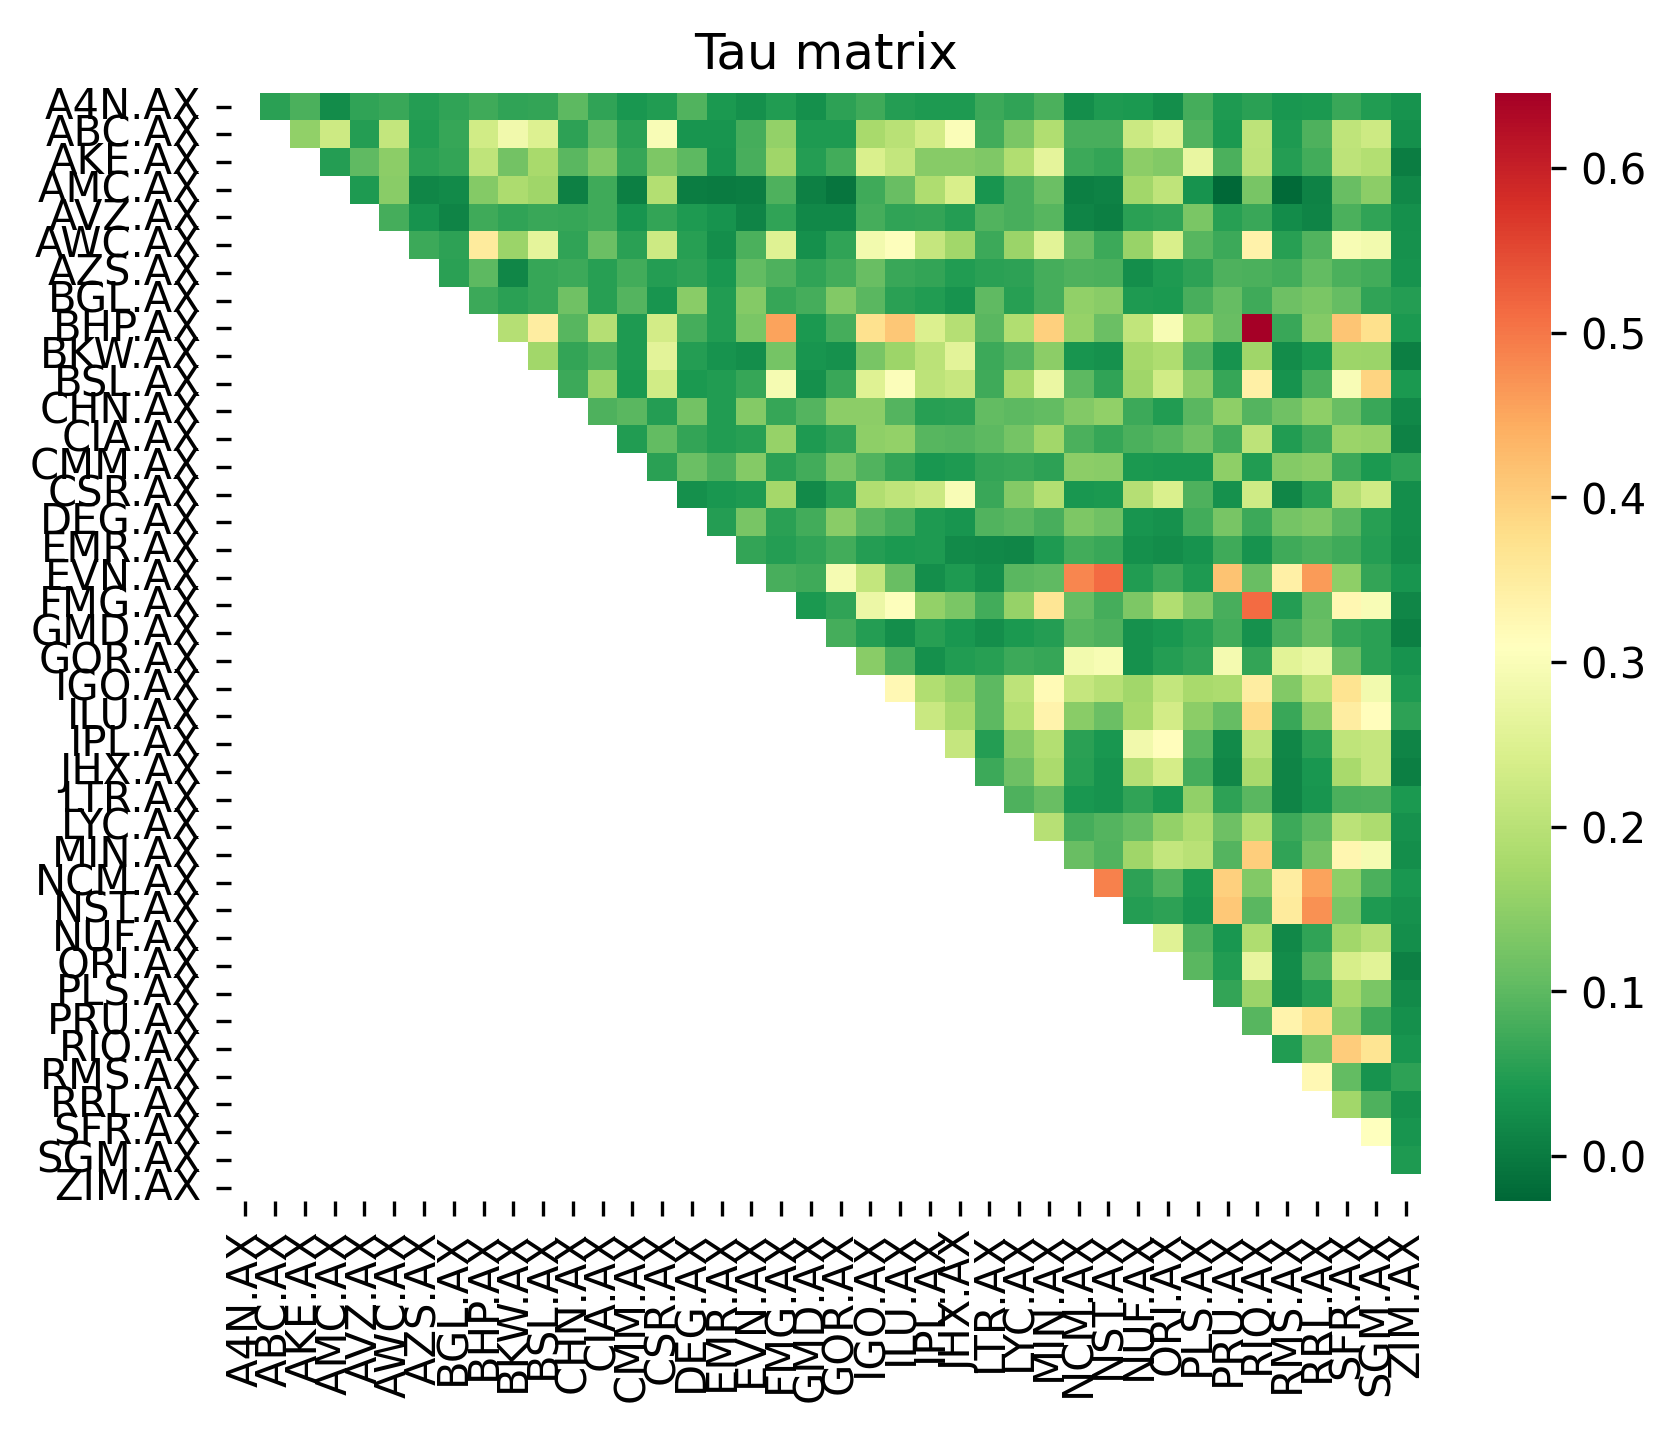

In [14]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
stockNames = list(data.columns)

m = [0,0.2,0.4,0.6,0.8,1]
# heatmap of pvalues
# seaborn.heatmap(pvalues, xticklabels=stockNames, 
#                 yticklabels=stockNames, cmap='RdYlGn_r' 
#                 , mask = (pvalues >= 0.98)
#                 )
# heatmap of tau with pvalue mask
sns.heatmap(tau_matrix, xticklabels=stockNames, 
                yticklabels=stockNames, cmap='RdYlGn_r' 
                , mask = (tau_matrix == 0)
                )
plt.title('Tau matrix')
plt.show()

#### Pvalue heatmap
something strange is happening

In [ ]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
stockNames = list(data.columns)

m = [0,0.2,0.4,0.6,0.8,1]
# heatmap of pvalues
sns.heatmap(pvalue_matrix, xticklabels=stockNames, 
                yticklabels=stockNames, cmap='RdYlGn_r' 
                , mask = (pvalue_matrix >= 0.98)
                )
plt.title('Pvalue matrix')
plt.show()

In [15]:
# finding the largest tau value
target = tau_matrix.max()
shape = np.shape(tau_matrix)
for r in range(shape[0]): # row
    for c in range(shape[1]): # column
        if tau_matrix[r][c] == target:
            print(stockNames[r], stockNames[c])
            print(f"kendall tau: {target}")
            print(f"pvalue: {pvalue_matrix[r][c]}")

BHP.AX RIO.AX
kendall tau: 0.6458066534038226
pvalue: 0.0


This is a bit strange, lets graph the two timeseries together

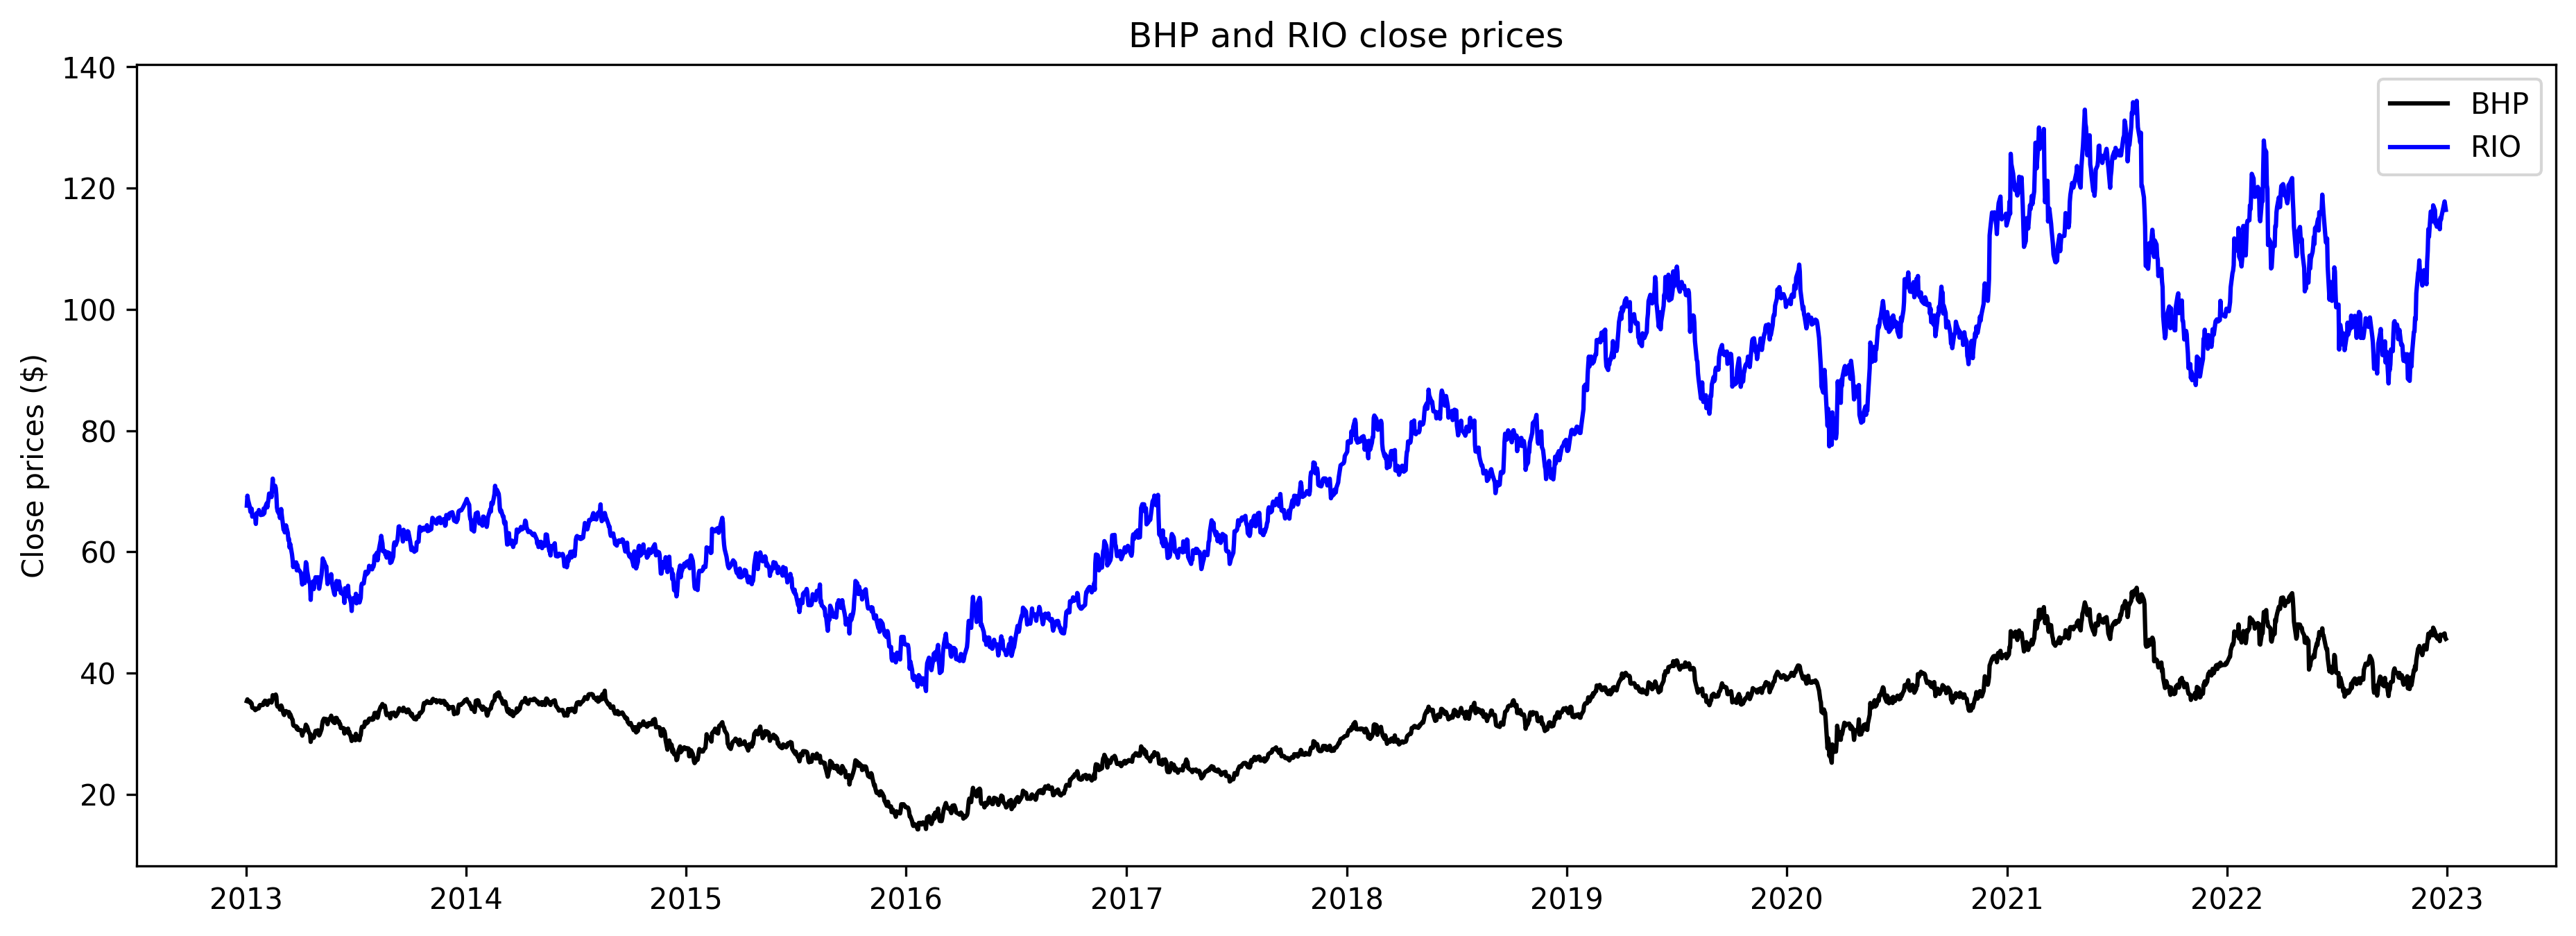

In [17]:
# Plot the two stocks
plt.figure(figsize=(15,5))
plt.plot(data.index, data["BHP.AX"], color='black')
plt.plot(data.index, data["RIO.AX"], color='blue')


plt.legend(['BHP', 'RIO'])
plt.title('BHP and RIO close prices')
plt.ylabel('Close prices ($)')
plt.show()

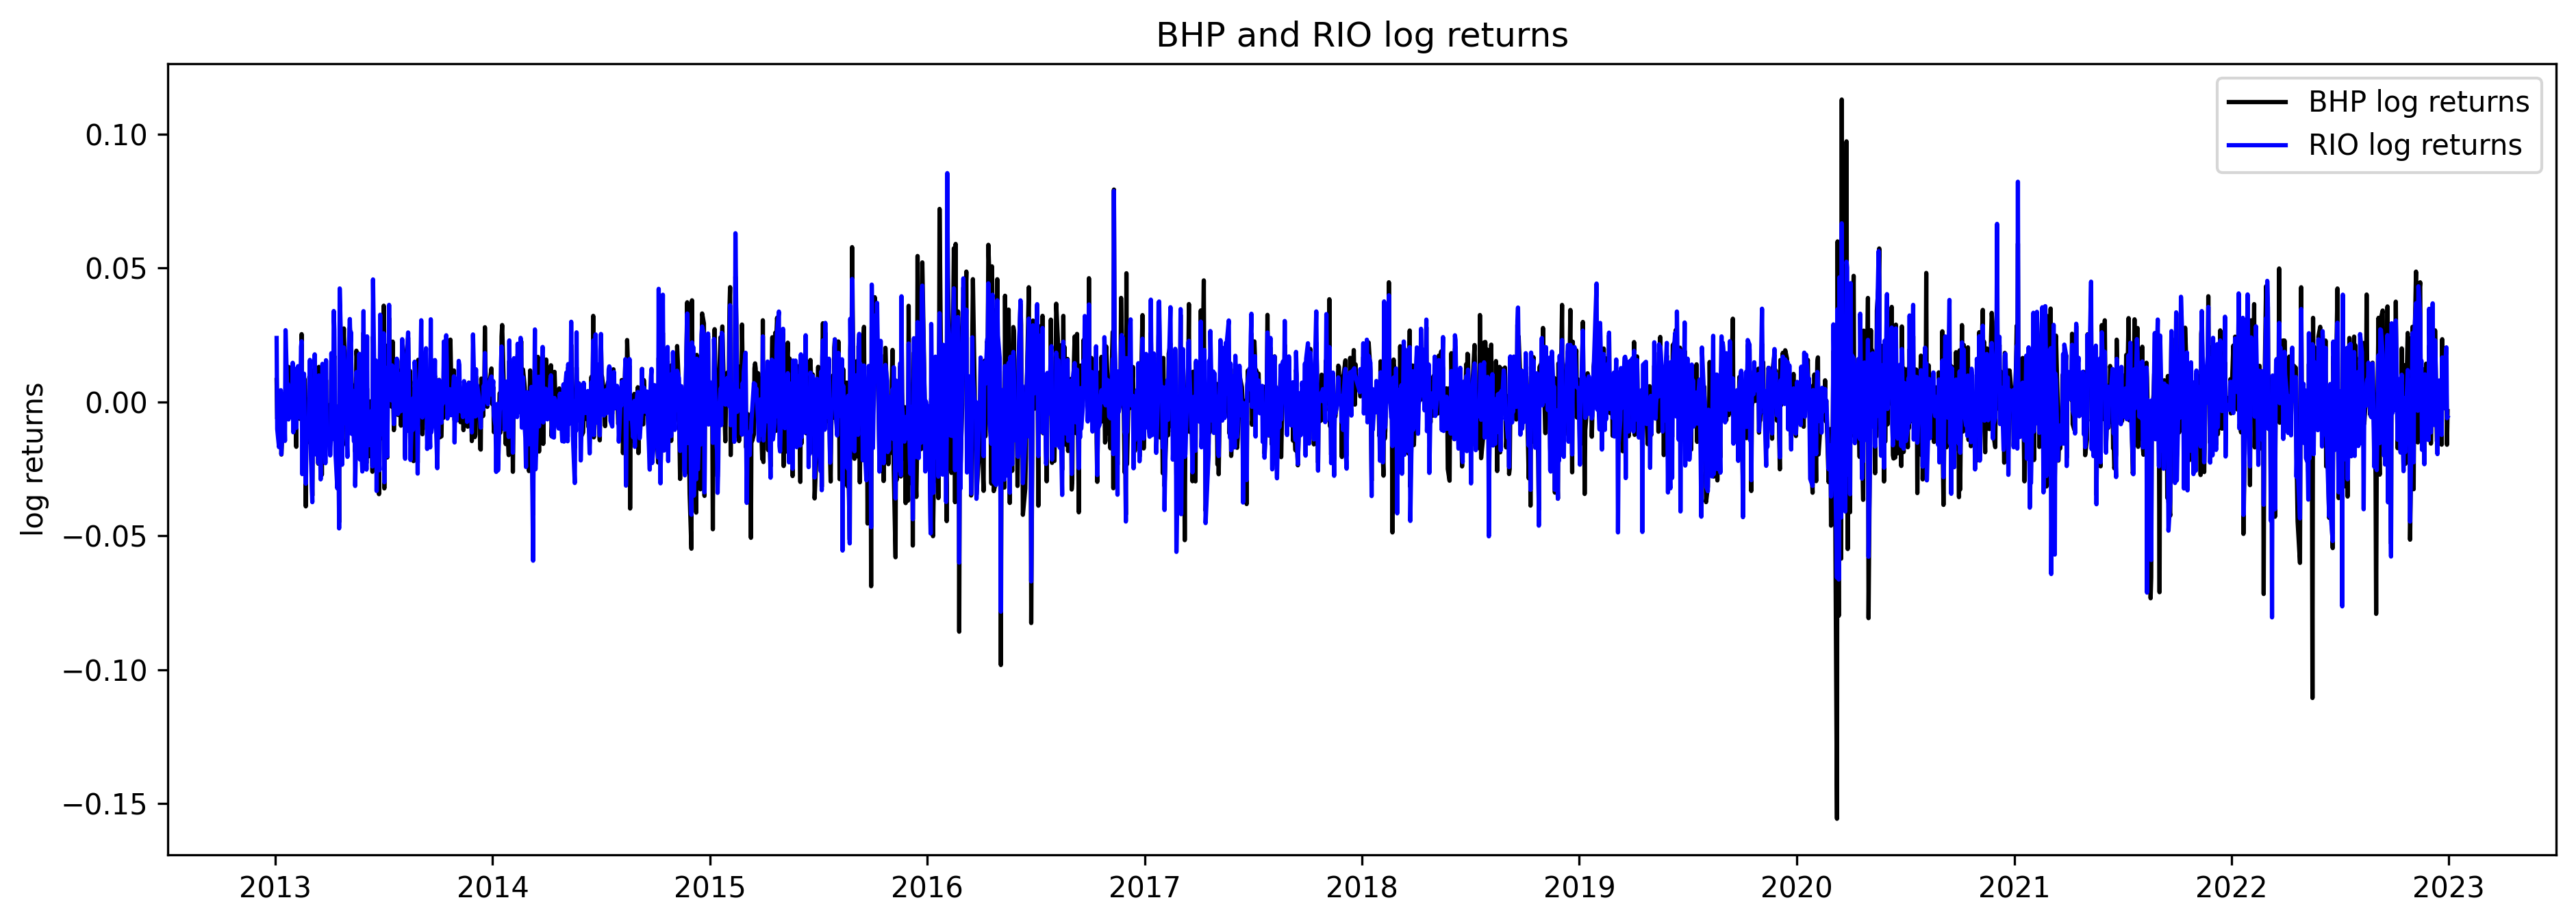

In [18]:
x = (np.log(data["BHP.AX"]) - np.log(data["BHP.AX"].shift(1)))
y = (np.log(data["RIO.AX"]) - np.log(data["RIO.AX"].shift(1)))

plt.figure(figsize=(15,5))
plt.plot(x.index, x, color='black')
plt.plot(y.index, y, color='blue')


plt.legend(['BHP log returns', 'RIO log returns'])
plt.title('BHP and RIO log returns')
plt.ylabel('log returns')
plt.show()

# Estimating the marginal distributions of log-return
create a CDF
use statsmodels ECDF funtion to avoid making assumptions about the distribution

In [99]:
# https://www.statsmodels.org/dev/generated/statsmodels.distributions.empirical_distribution.ECDF.html
# convert log returns of S1 and S2 to CDF

S1 = data['BHP.AX']
S2 = data['RIO.AX']

x = (np.log(data["BHP.AX"]) - np.log(data["BHP.AX"].shift(1)))
y = (np.log(data["RIO.AX"]) - np.log(data["RIO.AX"].shift(1)))

# cumulative distribution function (marginal distributions)
ecdf_x, ecdf_y  = ECDF(x), ECDF(y)
u, v = [ecdf_x(a) for a in x], [ecdf_y(a) for a in y]

# plt.figure(figsize=(15,5))
# plt.plot(u, color='black')
# plt.plot(v, color='blue')


# plt.legend(['BHP CDF', 'RIO CDF'])
# plt.title('BHP and RIO CDFs')
# plt.ylabel('CDF')
# plt.show()

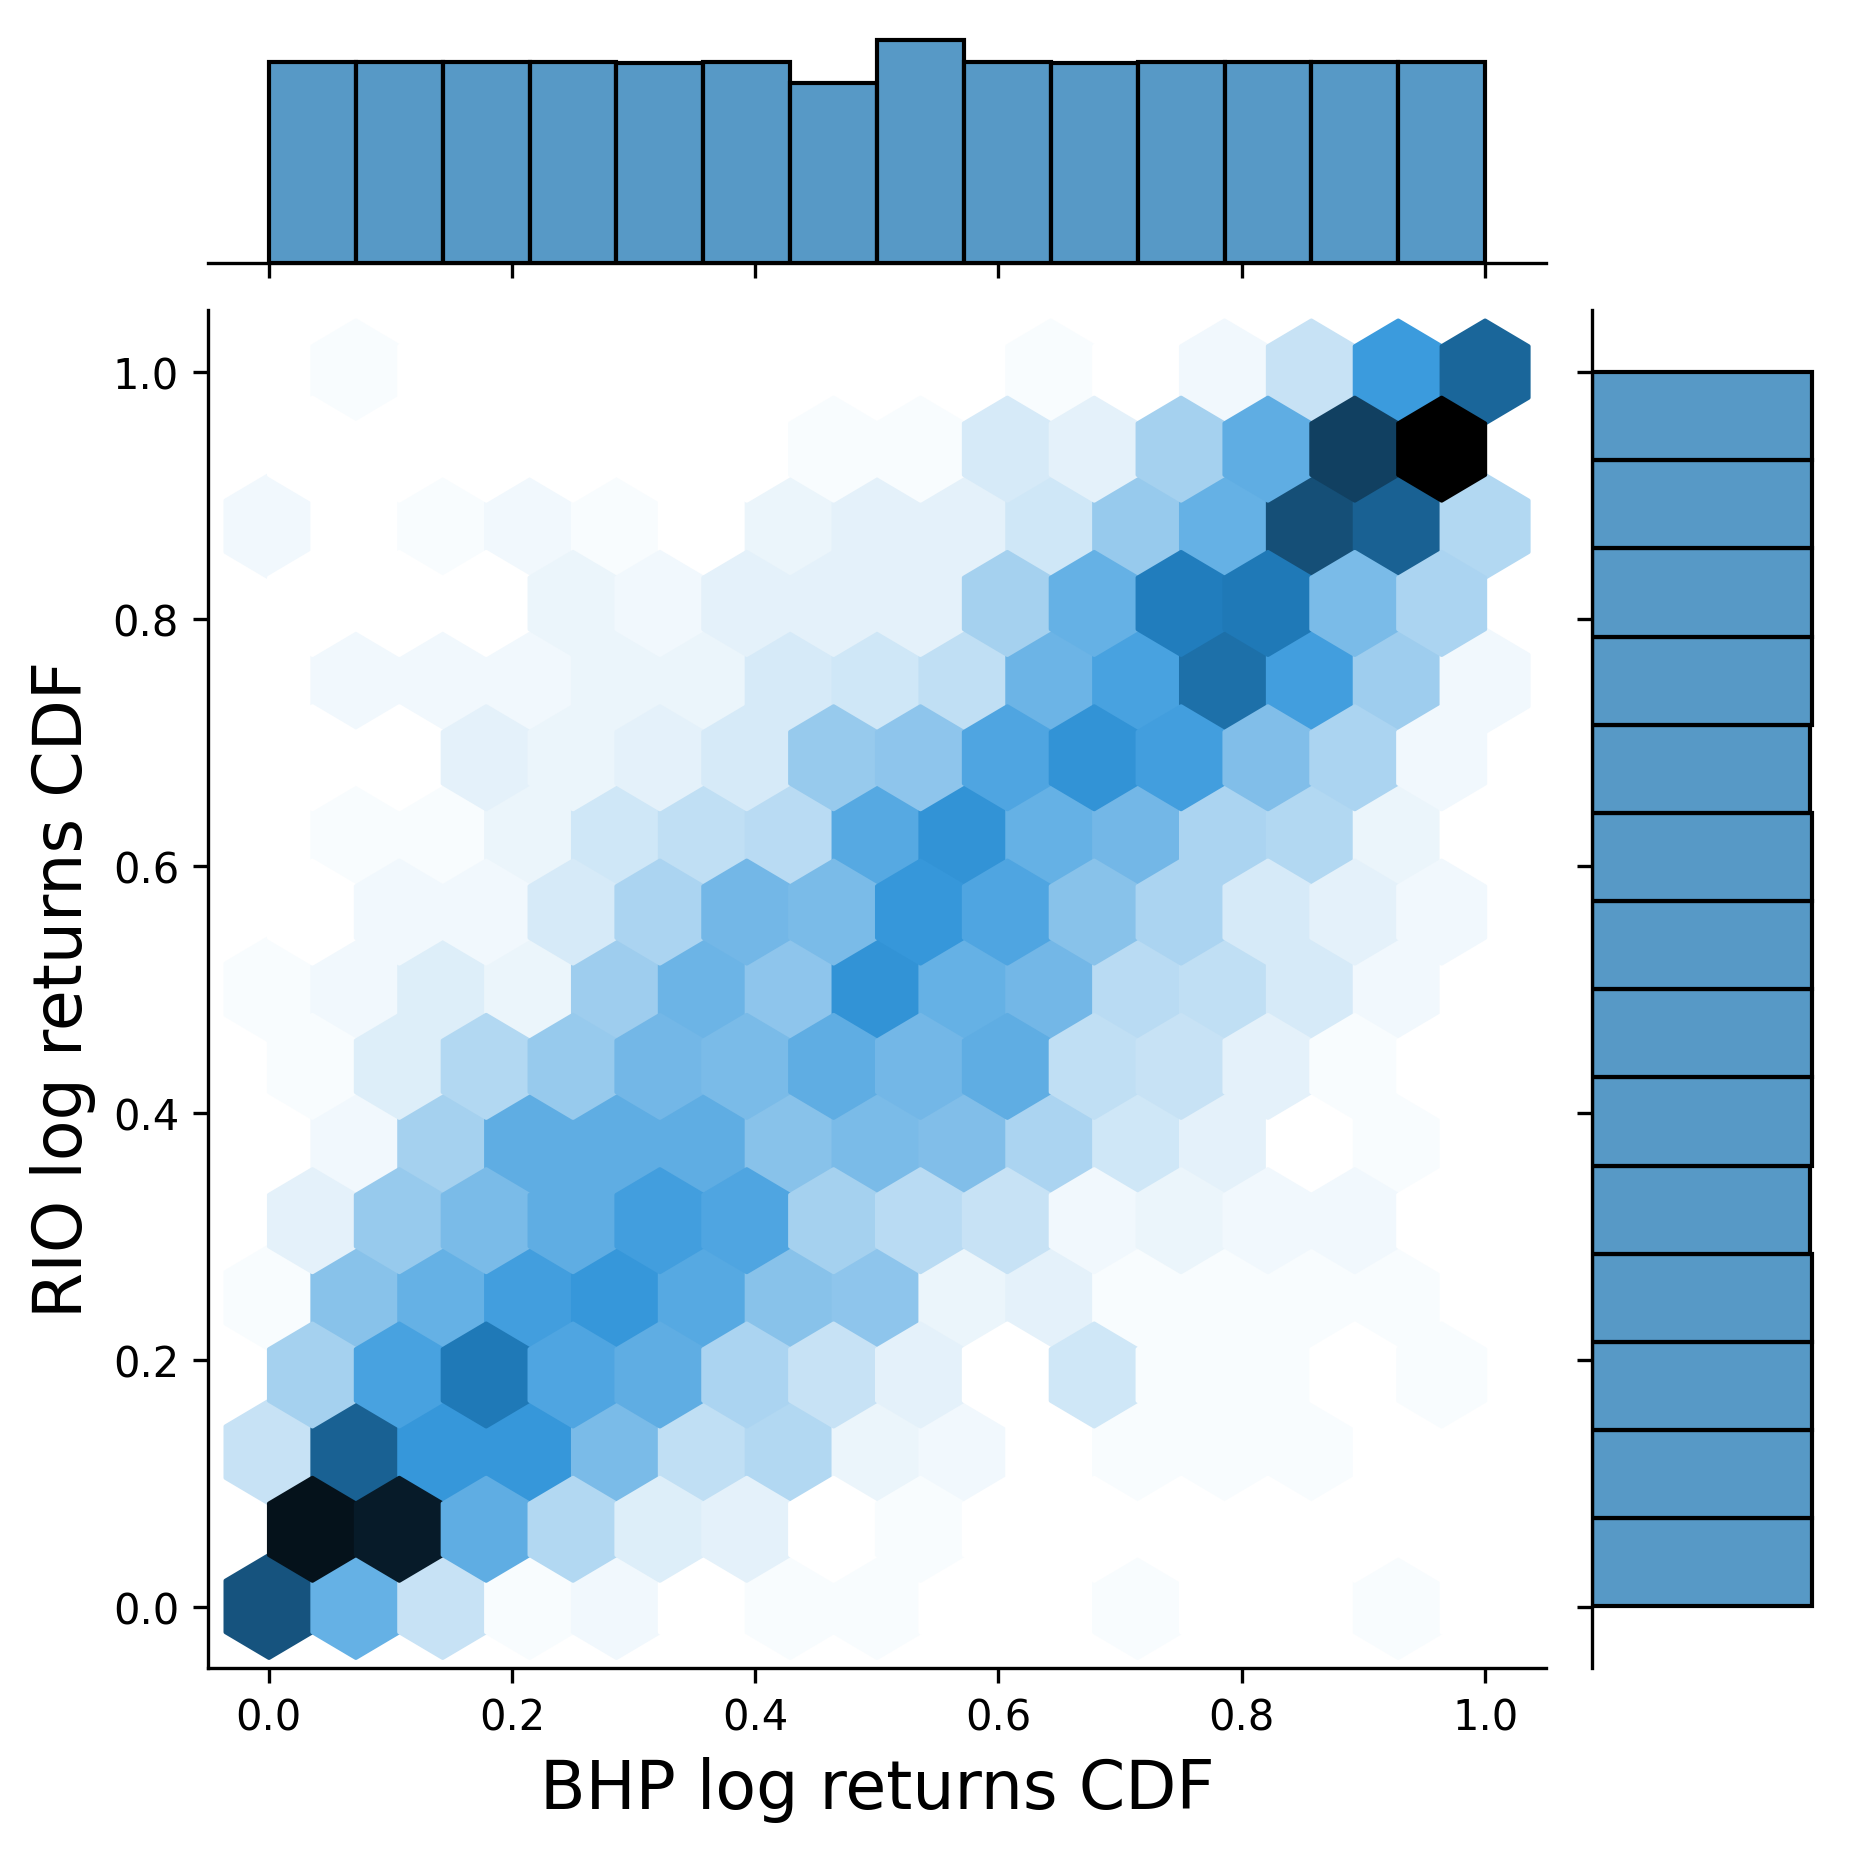

In [107]:
# ['scatter', 'hist', 'hex', 'kde', 'reg', 'resid']
h = sns.jointplot(x=u, y=v, kind="hex")
_ = h.set_axis_labels("BHP log returns CDF", "RIO log returns CDF", fontsize=16)

# Estimating copula parameters
this controls how strong the relationship is with the copula

add more copula families

In [219]:
def get_parameter(family, tau):
    # https://www.quantconnect.com/research/15298/pairs-trading-copula-vs-cointegration/p1
    ''' Estimate the parameters for three kinds of Archimedean copulas
    according to association between Archimedean copulas and the Kendall rank correlation measure
    
    '''
    if  family == 'clayton':
        return 2 * tau / (1 - tau)
    elif family == 'frank':
        '''
        debye = quad(integrand, sys.float_info.epsilon, theta)[0]/theta  is first order Debye function
        frank_fun is the squared difference
        Minimize the frank_fun would give the parameter theta for the frank copula 
        ''' 
        integrand = lambda t: t / (np.exp(t) - 1)  # generate the integrand
        frank_fun = lambda theta: ((tau - 1) / 4.0  - (quad(integrand, sys.float_info.epsilon, theta)[0] / theta - 1) / theta) ** 2
        return minimize(frank_fun, 4, method='BFGS', tol=1e-5).x 
    elif family == 'gumbel':
        return 1 / (1 - tau)

In [25]:
# testing the parameters
S1 = data['BKW.AX']
S2 = data['JHX.AX']
tau = kendall_tau(S1, S2)[0] 

get_parameter('clayton', tau)

0.7028949481561692

# Selecting the best fitting copula
it may be worth selecting the best stocks based off of how they fit to the data

using AIC criteria (Akaike Information criteria)

try and get this to work for other copulas

In [26]:
def get_lpdf_copula(family, theta, u, v):
    '''Estimate the log probability density function of three kinds of Archimedean copulas
    '''
    if  family == 'clayton':
        pdf = (theta + 1) * ((u ** (-theta) + v ** (-theta) - 1) ** (-2 - 1 / theta)) * (u ** (-theta - 1) * v ** (-theta - 1))
    elif family == 'frank':
        num = -theta * (np.exp(-theta) - 1) * (np.exp(-theta * (u + v)))
        denom = ((np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)) ** 2
        pdf = num / denom
    elif family == 'gumbel':
        A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
        c = np.exp(-A ** (1 / theta))
        pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))
    return np.log(pdf)

In [235]:
# testing the parameters
S1 = data['BHP.AX']
S2 = data['RIO.AX']

x = (np.log(data["BHP.AX"]) - np.log(data["BHP.AX"].shift(1)))
y = (np.log(data["RIO.AX"]) - np.log(data["RIO.AX"].shift(1)))

# cumulative distribution function (marginal distributions)
ecdf_x, ecdf_y  = ECDF(x), ECDF(y)
u, v = [ecdf_x(a) for a in x], [ecdf_y(a) for a in y]
family = "gumbel"
tau = kendall_tau(S1, S2)[0] 
theta = get_parameter(family, tau)
# following the AIC formula
lpdf = get_lpdf_copula(family, theta, u, v)
loglikelihood = lpdf.sum()
AIC = 2-2*loglikelihood
AIC

# For some reason other families do not work

TypeError: can't multiply sequence by non-int of type 'list'

### Mispricing index

In [42]:

def misprice_index(return_x, return_y, ecdf_x, ecdf_y, family, theta):
    # convert to empirical distribution
    u = ecdf_x(return_x)
    v = ecdf_y(return_y)

    if family == 'clayton':
            MI_u_v = v ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (-1 / theta - 1) # P(U<u|V=v)
            MI_v_u = u ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (-1 / theta - 1) # P(V<v|U=u)

        #   pdf = (theta + 1) * ((u ** (-theta) + v ** (-theta) - 1) ** (-2 - 1 / theta)) * (u ** (-theta - 1) * v ** (-theta - 1))

    elif family == 'frank':
        A = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * v) - 1)
        B = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * u) - 1)
        C = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)
        MI_u_v = B / C
        MI_v_u = A / C
    
    elif family == 'gumbel':
        A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
        C_uv = np.exp(-A ** (1 / theta))   # C_uv is gumbel copula function C(u,v)
        MI_u_v = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(v)) ** (theta - 1) * (1.0 / v)
        MI_v_u = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(u)) ** (theta - 1) * (1.0 / u)
        
    return MI_u_v, MI_v_u

S1 = data['BHP.AX']
S2 = data['RIO.AX']

x = (np.log(data["BHP.AX"]) - np.log(data["BHP.AX"].shift(1)))
y = (np.log(data["RIO.AX"]) - np.log(data["RIO.AX"].shift(1)))

# cumulative distribution function (marginal distributions)
ecdf_x, ecdf_y  = ECDF(x), ECDF(y)

family = "clayton"
tau = kendall_tau(S1, S2)[0] 
theta = get_parameter(family, tau)

return_x = x[-1]
return_y = y[-1]

misprice_index(return_x, return_y, ecdf_x, ecdf_y, family, theta)

(0.5700818911568718, 0.2811046395264929)

In [36]:
# get the coefficient of the gradient
coef = stats.linregress(x[1:],y[1:]).slope
coef

0.7682782564010258

## Simulate trading

todo: make all the testing stuff rolling over the previous 90 days (or some other variable)


In [96]:
# construct the copula using training data and test the relationshi with testing data
np.seterr(divide='ignore', invalid='ignore')

#? update the testing data over a rolling window?
#todo add an option to exit positions

long = "BHP.AX"
short = "RIO.AX"
family = "clayton"
lookback = None # length of total history data (about 10 years)
num_days = 90 # number of days to form the copula
lower_CL = 0.05
upper_CL = 0.95

weight_S2 = 1 # desired holding weight of asset v in the portfolio
#todo maybe exit threshold

S1 = data[long]
S2 = data[short]

train_split = int(round(0.7*len(S1),0))
train_S1, train_S2 = S1[:train_split], S2[:train_split]
test_S1, test_S2 = S1[train_split:], S2[train_split:]

# Setup copula with training data
train_x = (np.log(train_S1) - np.log(train_S1.shift(1))) # drop the nan at start
train_y = (np.log(train_S2) - np.log(train_S2.shift(1)))

test_x = (np.log(test_S1) - np.log(test_S1.shift(1))) # drop the nan at start
test_y = (np.log(test_S2) - np.log(test_S2.shift(1)))

# cumulative distribution function (marginal distributions)
ecdf_x, ecdf_y  = ECDF(train_x), ECDF(train_y)
# get the last terms

# Setting up all the variables
tau = kendall_tau(train_S1[1:], train_S2[1:])[0]
theta = get_parameter(family, tau)

coef = stats.linregress(train_x[1:],train_y[1:]).slope

start_cash = 0
returns = start_cash
returnsSeries = 0*test_S1
totalReturnsSeries = 0*test_S1
buy = 0*test_S1
sell = 0*test_S1
amount_S1 = 0
amount_S2 = 0
# start at len+1 to avoid the nan from the log returns
for i in range(1, len(test_S1), 1): # would use the lookback window here, and update the copula every day
    price_S1, price_S2 = test_S1[i], test_S2[i]
    if price_S2 == 0:
        print("breaking",i)
        break

    x, y = test_x[i], test_y[i]

    MI_u_v, MI_v_u = misprice_index(x, y, ecdf_x, ecdf_y, family, theta)

    # if long is undervalued, buy the pair
    # if S1 is undervalued and S2 is overvalued, go long
    # Sell S2 by weight, and buy S1 by weight * coefficient * long/short price ratio
    if MI_u_v < lower_CL and MI_v_u > upper_CL:
        # sell S2 by weight
        amount_S2 -= weight_S2
        returns += weight_S2*price_S2
        # buy S1 by weight * coefficient * long/short price ratio
        amount_S1 += (weight_S2 * coef * (price_S1/price_S2))
        returns -= (weight_S2 * coef * (price_S1/price_S2))*price_S1
        buy[i] = price_S1
        sell[i] = price_S2

    # Buy S2 by weight, sell S1 by weight * coefficient * long/short price ratio
    elif MI_u_v > lower_CL and MI_v_u < upper_CL:
        # buy S2 by weight
        amount_S2 += weight_S2
        returns -= weight_S2*price_S2
        # sell S1 by weight * coefficient * long/short price ratio
        amount_S1 -= (weight_S2 * coef * (price_S1/price_S2))
        returns += (weight_S2 * coef * (price_S1/price_S2))*price_S1
        sell[i] = price_S1
        buy[i] = price_S2
    returnsSeries[i] = returns
    totalReturnsSeries[i] = returns + amount_S1*price_S1 + amount_S2*price_S2


totalReturns = returns + amount_S1*price_S1 + amount_S2*price_S2
print(f"Cash: ${returns} from a starting of ${start_cash}, {amount_S1} S1 at ${price_S1} each, {amount_S2} S2 at ${price_S2} each")
print(f"giving overall ${totalReturns-start_cash} in returns")


Cash: $-55896.80110364997 from a starting of $0, -191.79225092015304 S1 at $45.630001068115234 each, 603 S2 at $116.41000366210938 each
giving overall $5546.95049025918 in returns


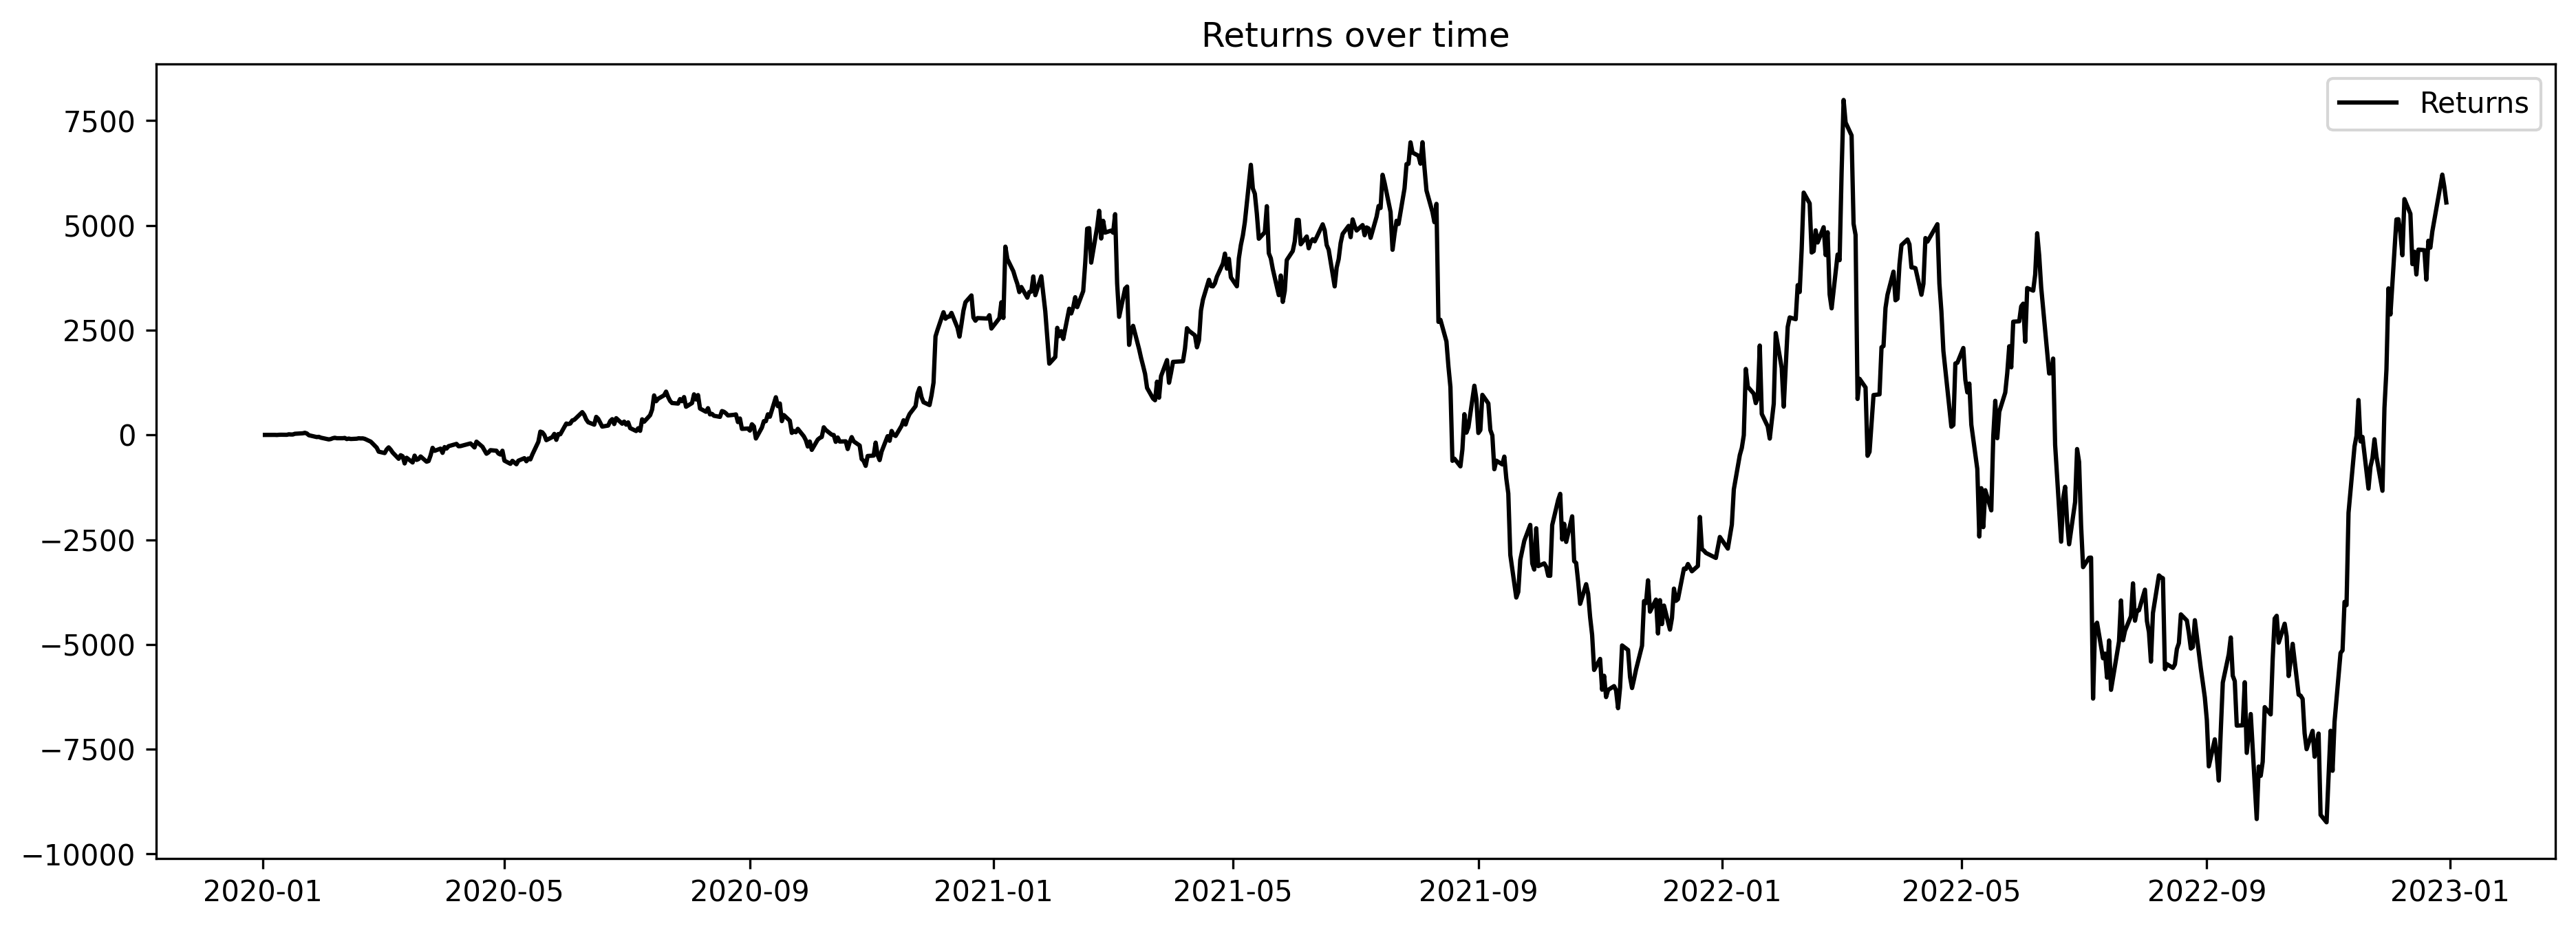

In [93]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time")
plt.plot(totalReturnsSeries, color='black')
plt.legend(['Returns'])
plt.show()

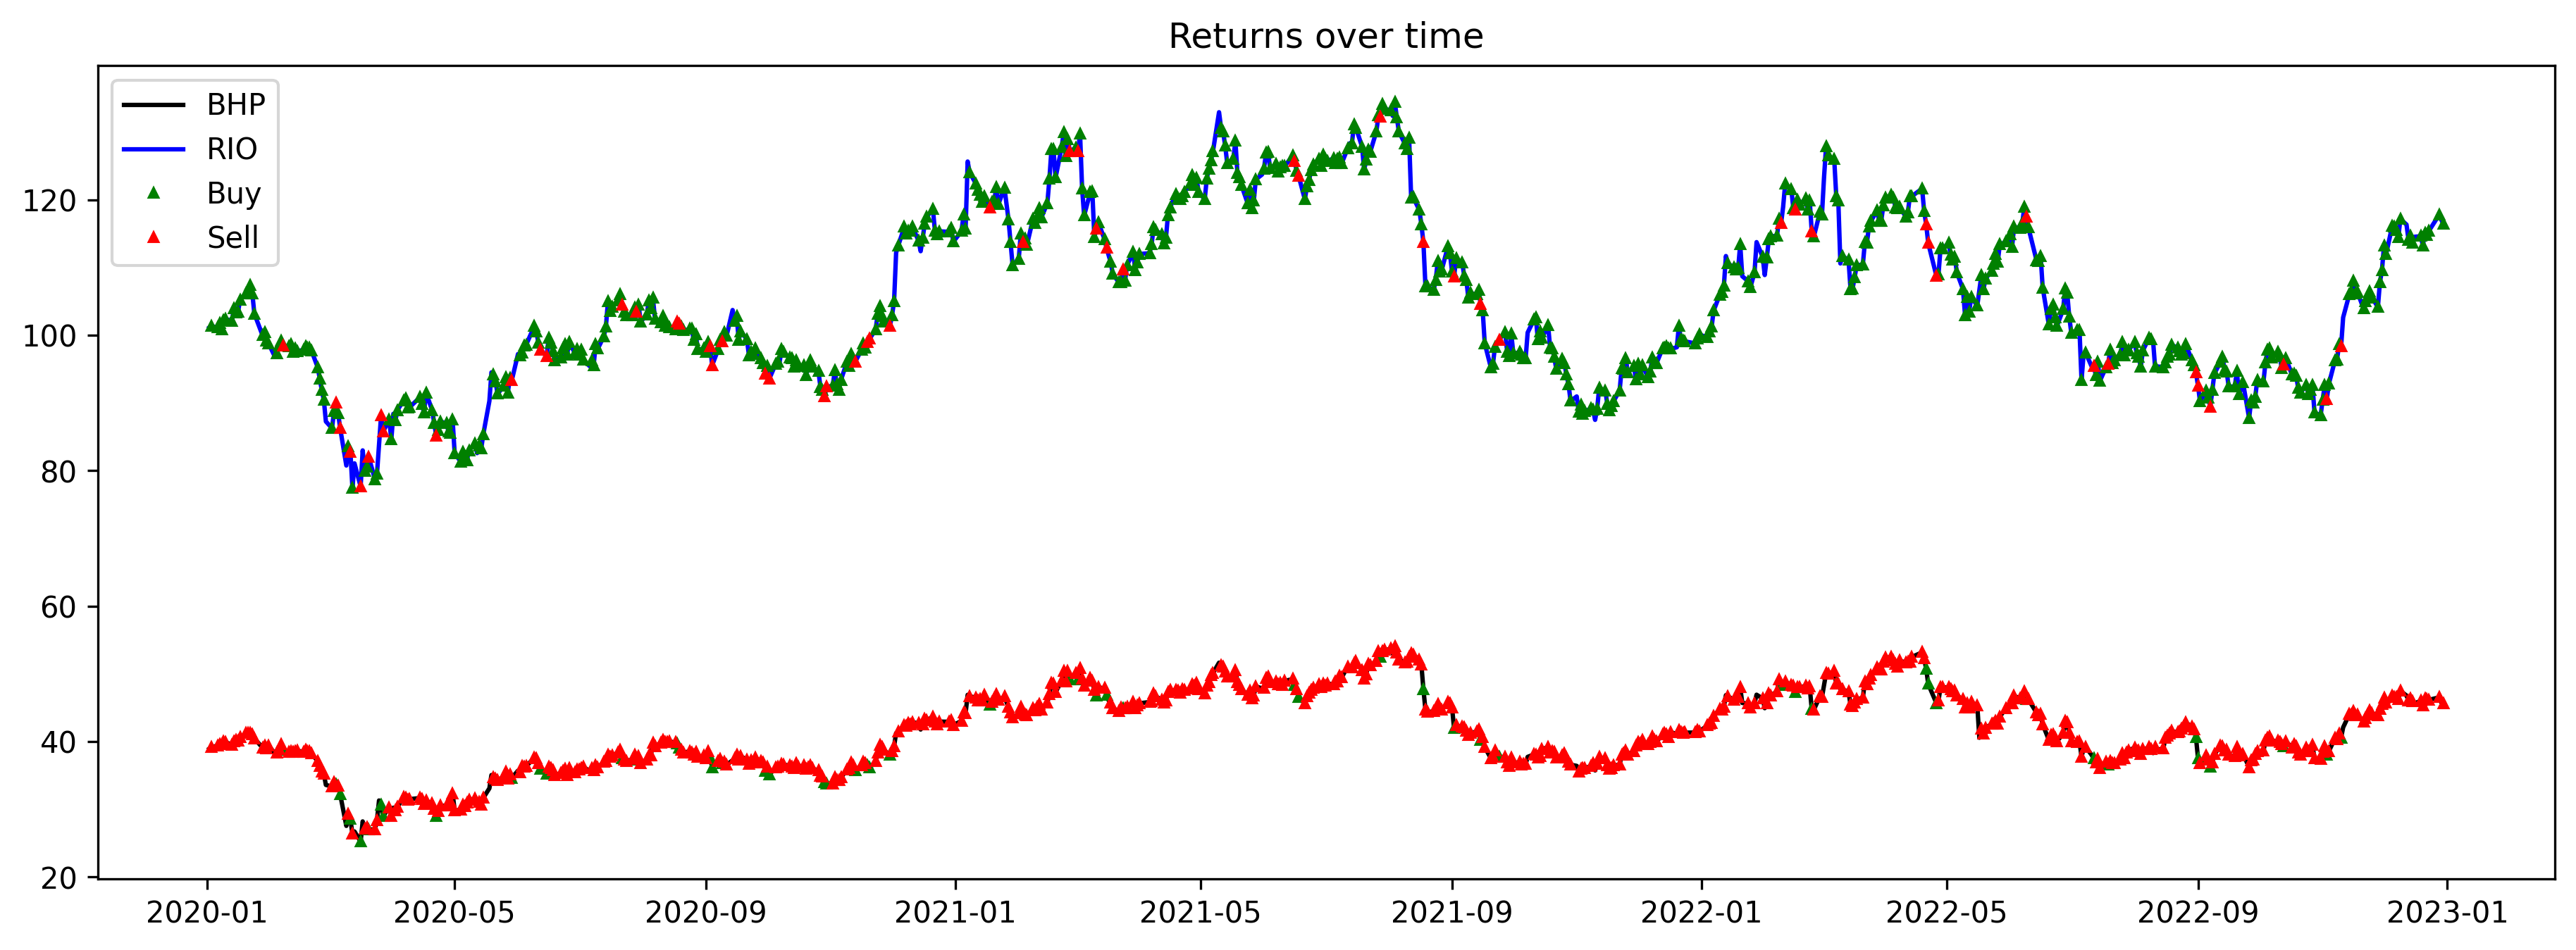

In [95]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time")
plt.plot(test_S1, color='black')
plt.plot(test_S2, color='blue')
plt.plot(buy.where(buy>0), color='green', linestyle='None', marker='^', markersize=3)
plt.plot(sell.where(sell>0), color='red', linestyle='None', marker='^', markersize=3)
plt.legend(['BHP', 'RIO', 'Buy', 'Sell'])
plt.show()

# Using a rolling copula (only one copula type)

figure out how to add other copula types, and make a function to determine the best copula for the period

In [226]:
np.seterr(divide='ignore', invalid='ignore')


# pass in data

## Copula variables
lookback = 90
lower_CL = 0.05
upper_CL = 0.95
exit_TH = 0.5
name_S1 = "BHP.AX"
name_S2 = "RIO.AX"
family = "gumbel"
## raw close data
S1 = data[name_S1]
S2 = data[name_S2]
## Trading variables
weight_S2 = 1 # desired holding weight of asset S2 in the portfolio
start_cash = 0
returns = start_cash
returnsSeries = 0*S1
totalReturnsSeries = 0*S1
tauSeries = 0*S1

buy = 0*S1
sell = 0*S1
liquidateS1 = 0*S1
liquidateS2 = 0*S1

MI_u_v = 0*S1
MI_v_u = 0*S1
# totalReturnsSeries = 0*test_S1
# buy = 0*test_S1
# sell = 0*test_S1
amount_S1 = 0
amount_S2 = 0

tau = 0
for i in range(lookback+1, len(S1), 1): # add 1 to avoid the nan at start

    ## Setup the copula
    S1_rolling = S1[i-lookback-1:i]
    S2_rolling = S2[i-lookback-1:i]
    # log returns
    x = (np.log(S1_rolling) - np.log(S1_rolling.shift(1)))[1:]
    y = (np.log(S2_rolling) - np.log(S2_rolling.shift(1)))[1:]
    # Empirical cumulative distribution function
    ecdf_x, ecdf_y  = ECDF(x), ECDF(y)

    tau = stats.kendalltau(x,y)[0]
    tauSeries[i] = tau
    theta = get_parameter(family, tau)

    coef = stats.linregress(x, y).slope
    
    MI_u_v[i], MI_v_u[i] = misprice_index(x[-1], y[-1], ecdf_x, ecdf_y, family, theta)

    ## Make trades 
    price_S1, price_S2 = S1_rolling[-1], S2_rolling[-1]
    
    # if S1 is undervalued and S2 is overvalued, go long
    # Sell S2 by weight, and buy S1 by weight * coefficient * long/short price ratio
    if MI_u_v[i] < lower_CL and MI_v_u[i] > upper_CL:
        # sell S2 by weight
        amount_S2 -= weight_S2
        returns += weight_S2*price_S2
        # buy S1 by weight * coefficient * long/short price ratio
        amount_S1 += (weight_S2 * coef * (price_S1/price_S2))
        returns -= (weight_S2 * coef * (price_S1/price_S2))*price_S1
        # update timeseries
        buy[i] = price_S1
        sell[i] = price_S2

    # Buy S2 by weight, sell S1 by weight * coefficient * long/short price ratio
    elif MI_u_v[i] > lower_CL and MI_v_u[i] < upper_CL:
        # buy S2 by weight
        amount_S2 += weight_S2
        returns -= weight_S2*price_S2
        # sell S1 by weight * coefficient * long/short price ratio
        amount_S1 -= (weight_S2 * coef * (price_S1/price_S2))
        returns += (weight_S2 * coef * (price_S1/price_S2))*price_S1
        # update timeseries
        sell[i] = price_S1
        buy[i] = price_S2

    # if it crosses the exit threshold, liquidate positions
    elif ((MI_u_v[i] < exit_TH and MI_u_v[i-1] > exit_TH) or (MI_u_v[i] > exit_TH and MI_u_v[i-1] < exit_TH)) \
     and ((MI_v_u[i] < exit_TH and MI_v_u[i-1] > exit_TH) or (MI_v_u[i] > exit_TH and MI_v_u[i-1] < exit_TH)):
        
        returns += amount_S1*price_S1 + amount_S2*price_S2
        amount_S1 = 0
        amount_S2 = 0

        liquidateS1[i] = price_S1
        liquidateS2[i] = price_S2

    returnsSeries[i] = returns
    totalReturnsSeries[i] = returns + amount_S1*price_S1 + amount_S2*price_S2
print(totalReturnsSeries[-1])

7426.629938554168


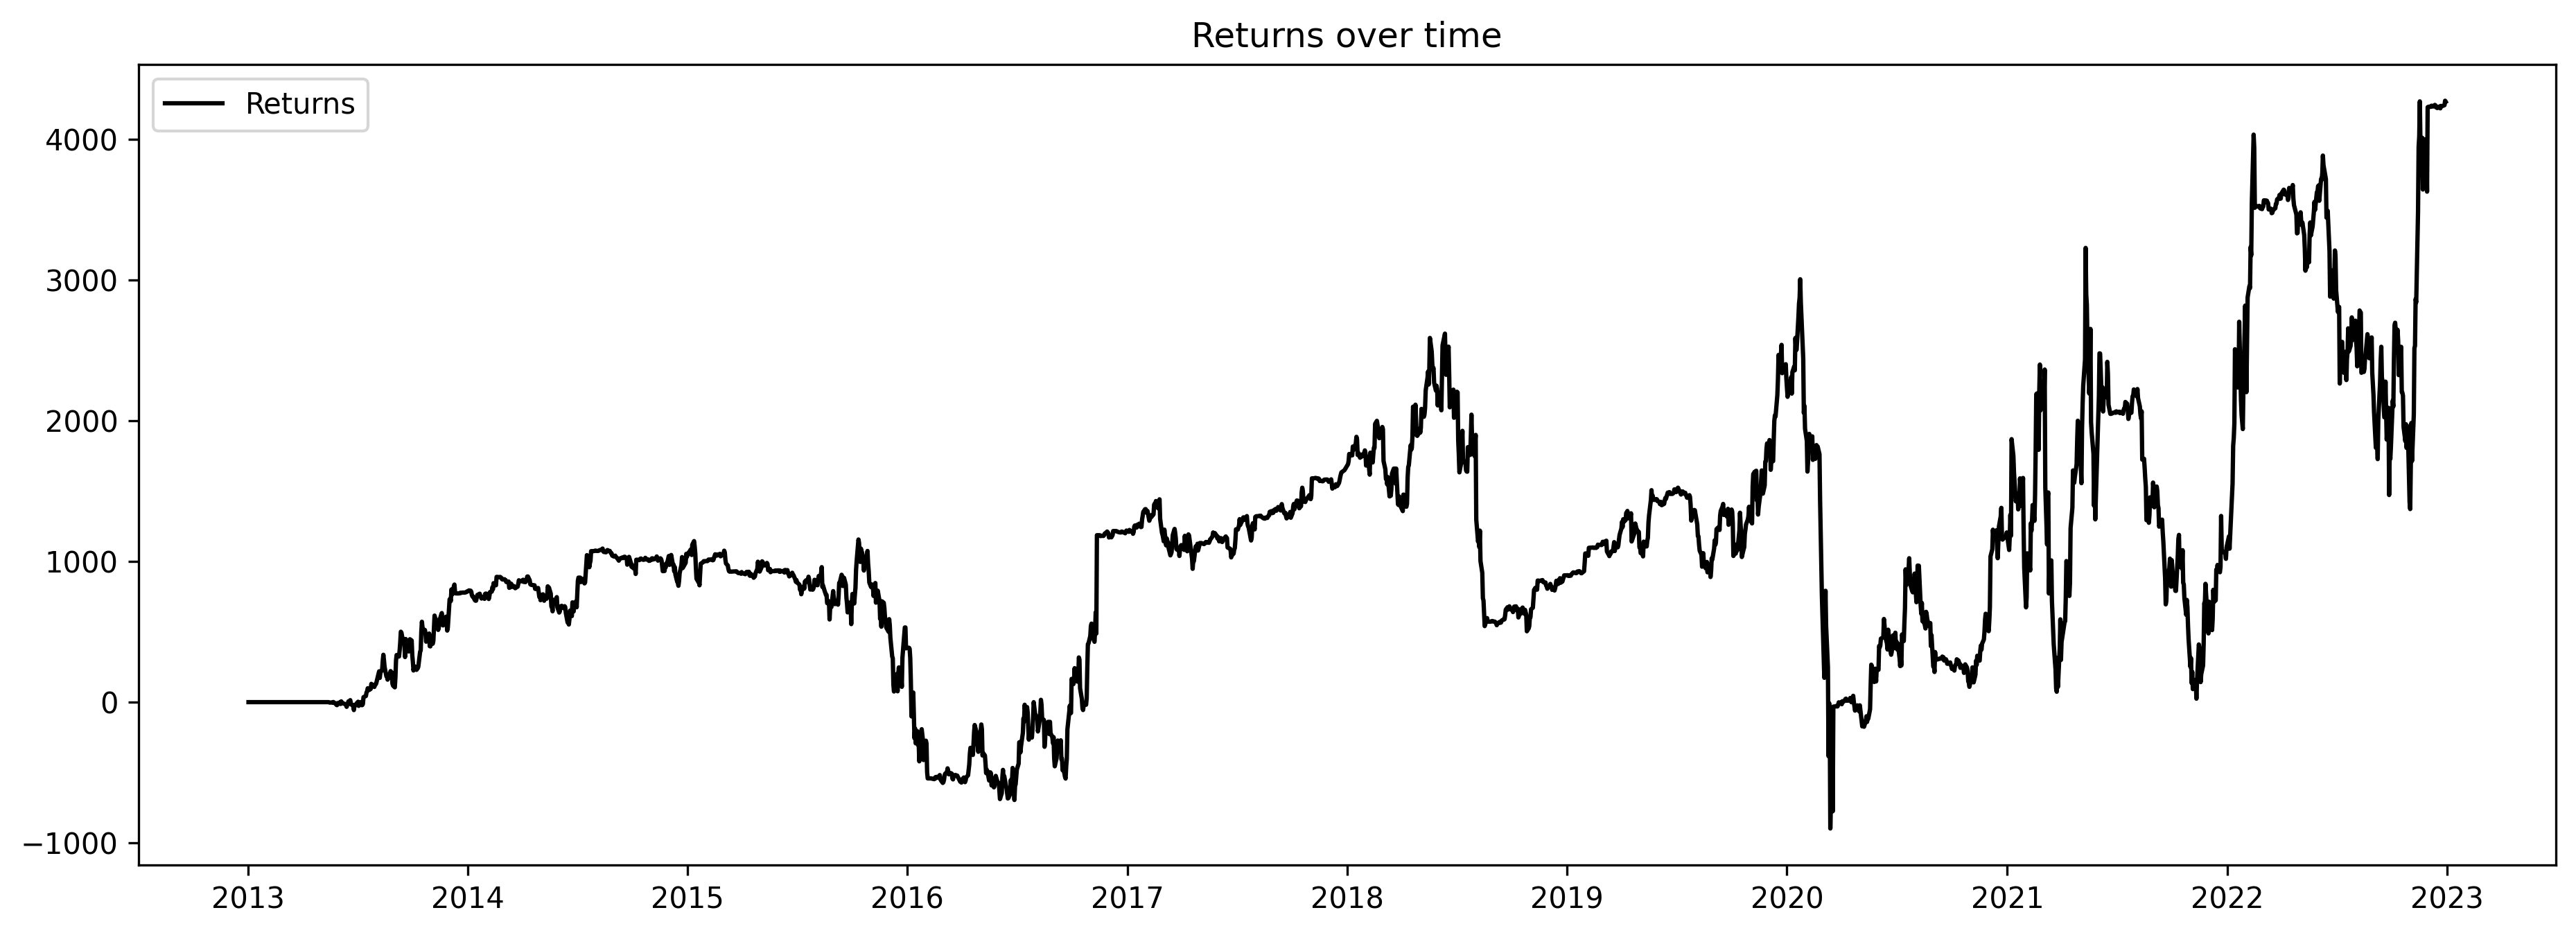

In [224]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time")
plt.plot(totalReturnsSeries, color='black')
plt.legend(['Returns'])
plt.show()

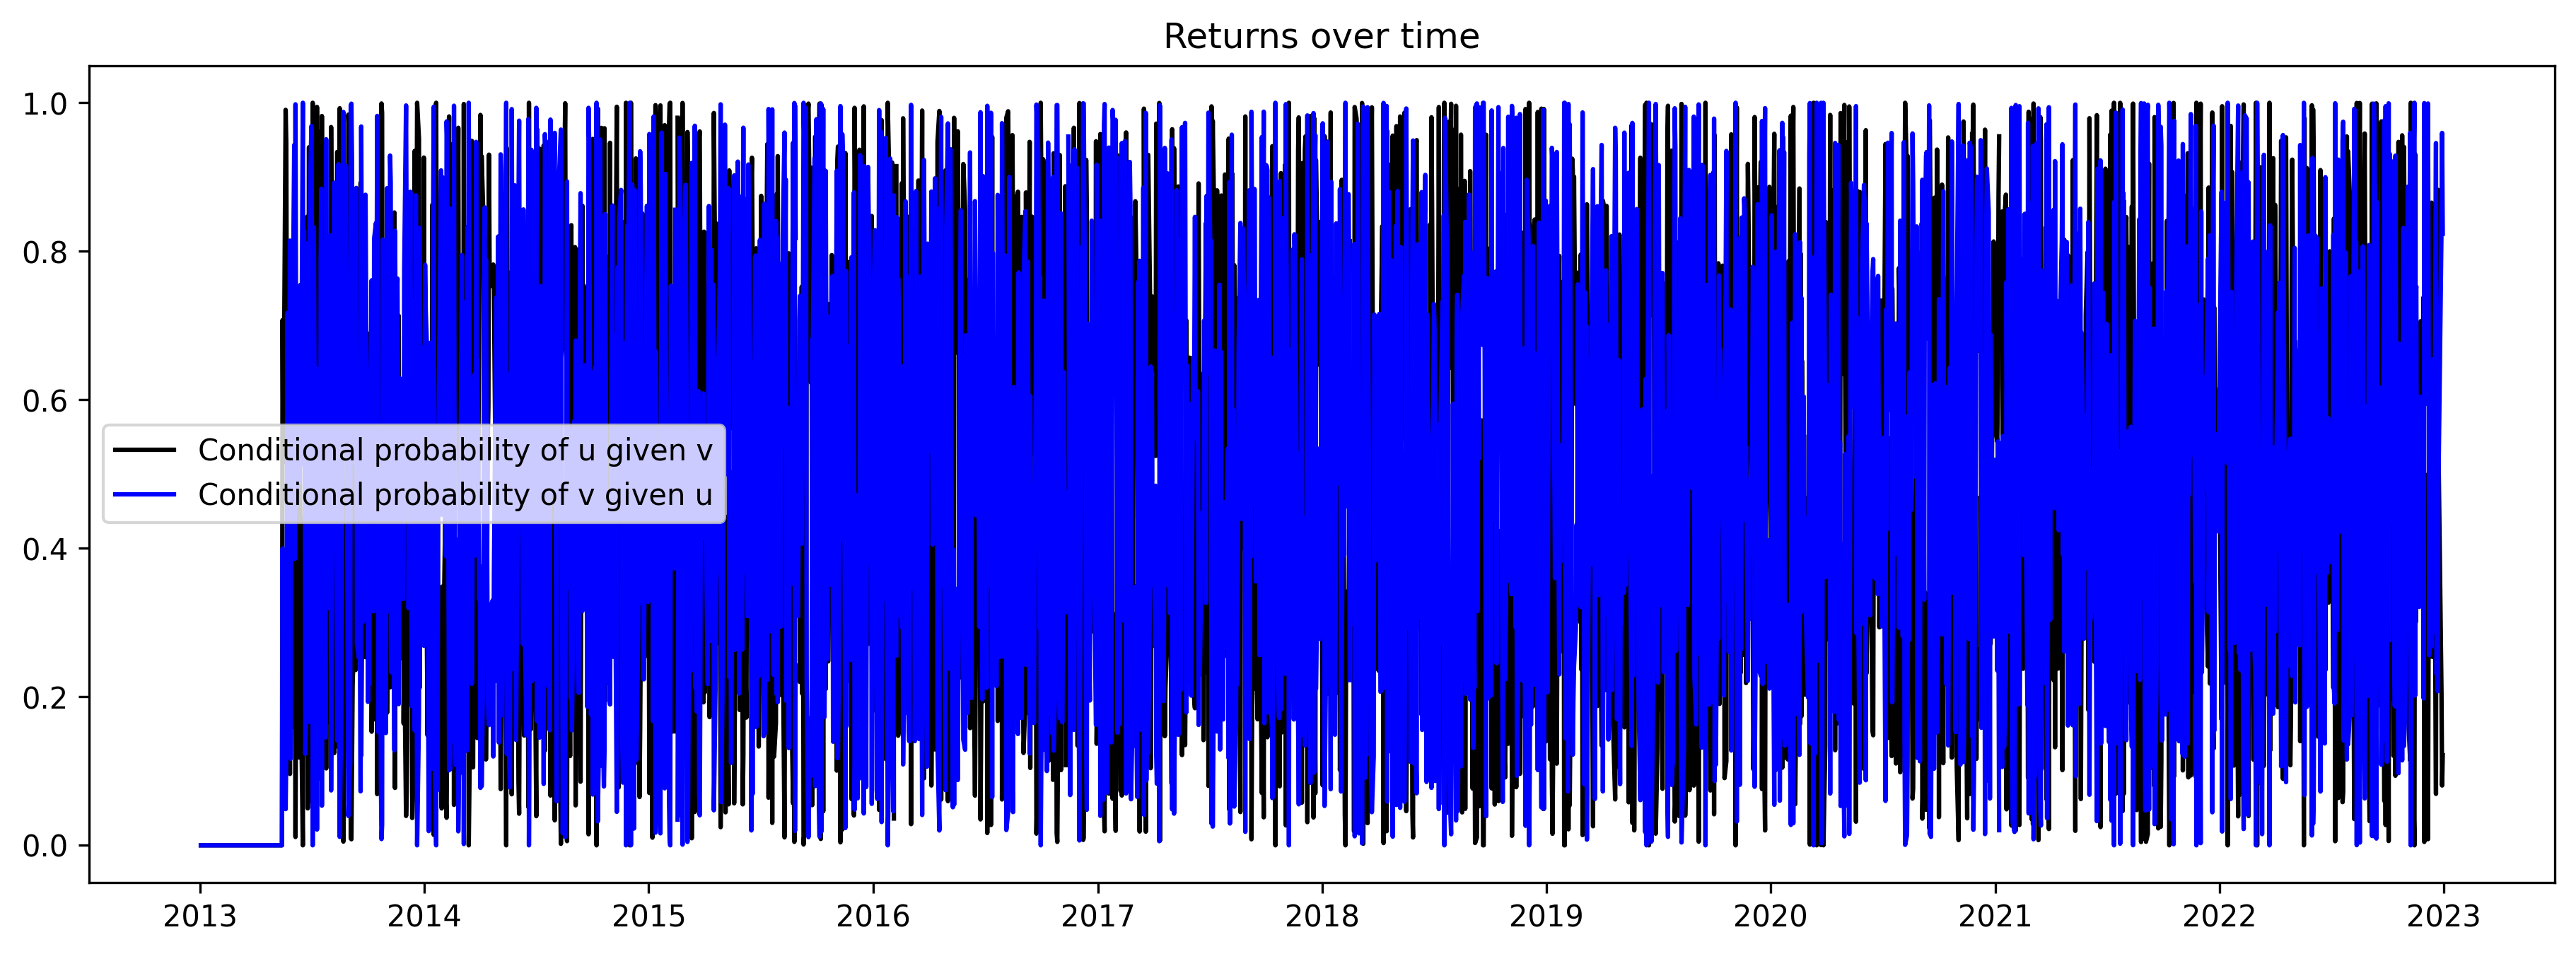

In [228]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time")
plt.plot(MI_u_v, color='black')
plt.plot(MI_v_u, color='blue')

plt.legend(['Conditional probability of u given v', 'Conditional probability of v given u'])
plt.show()

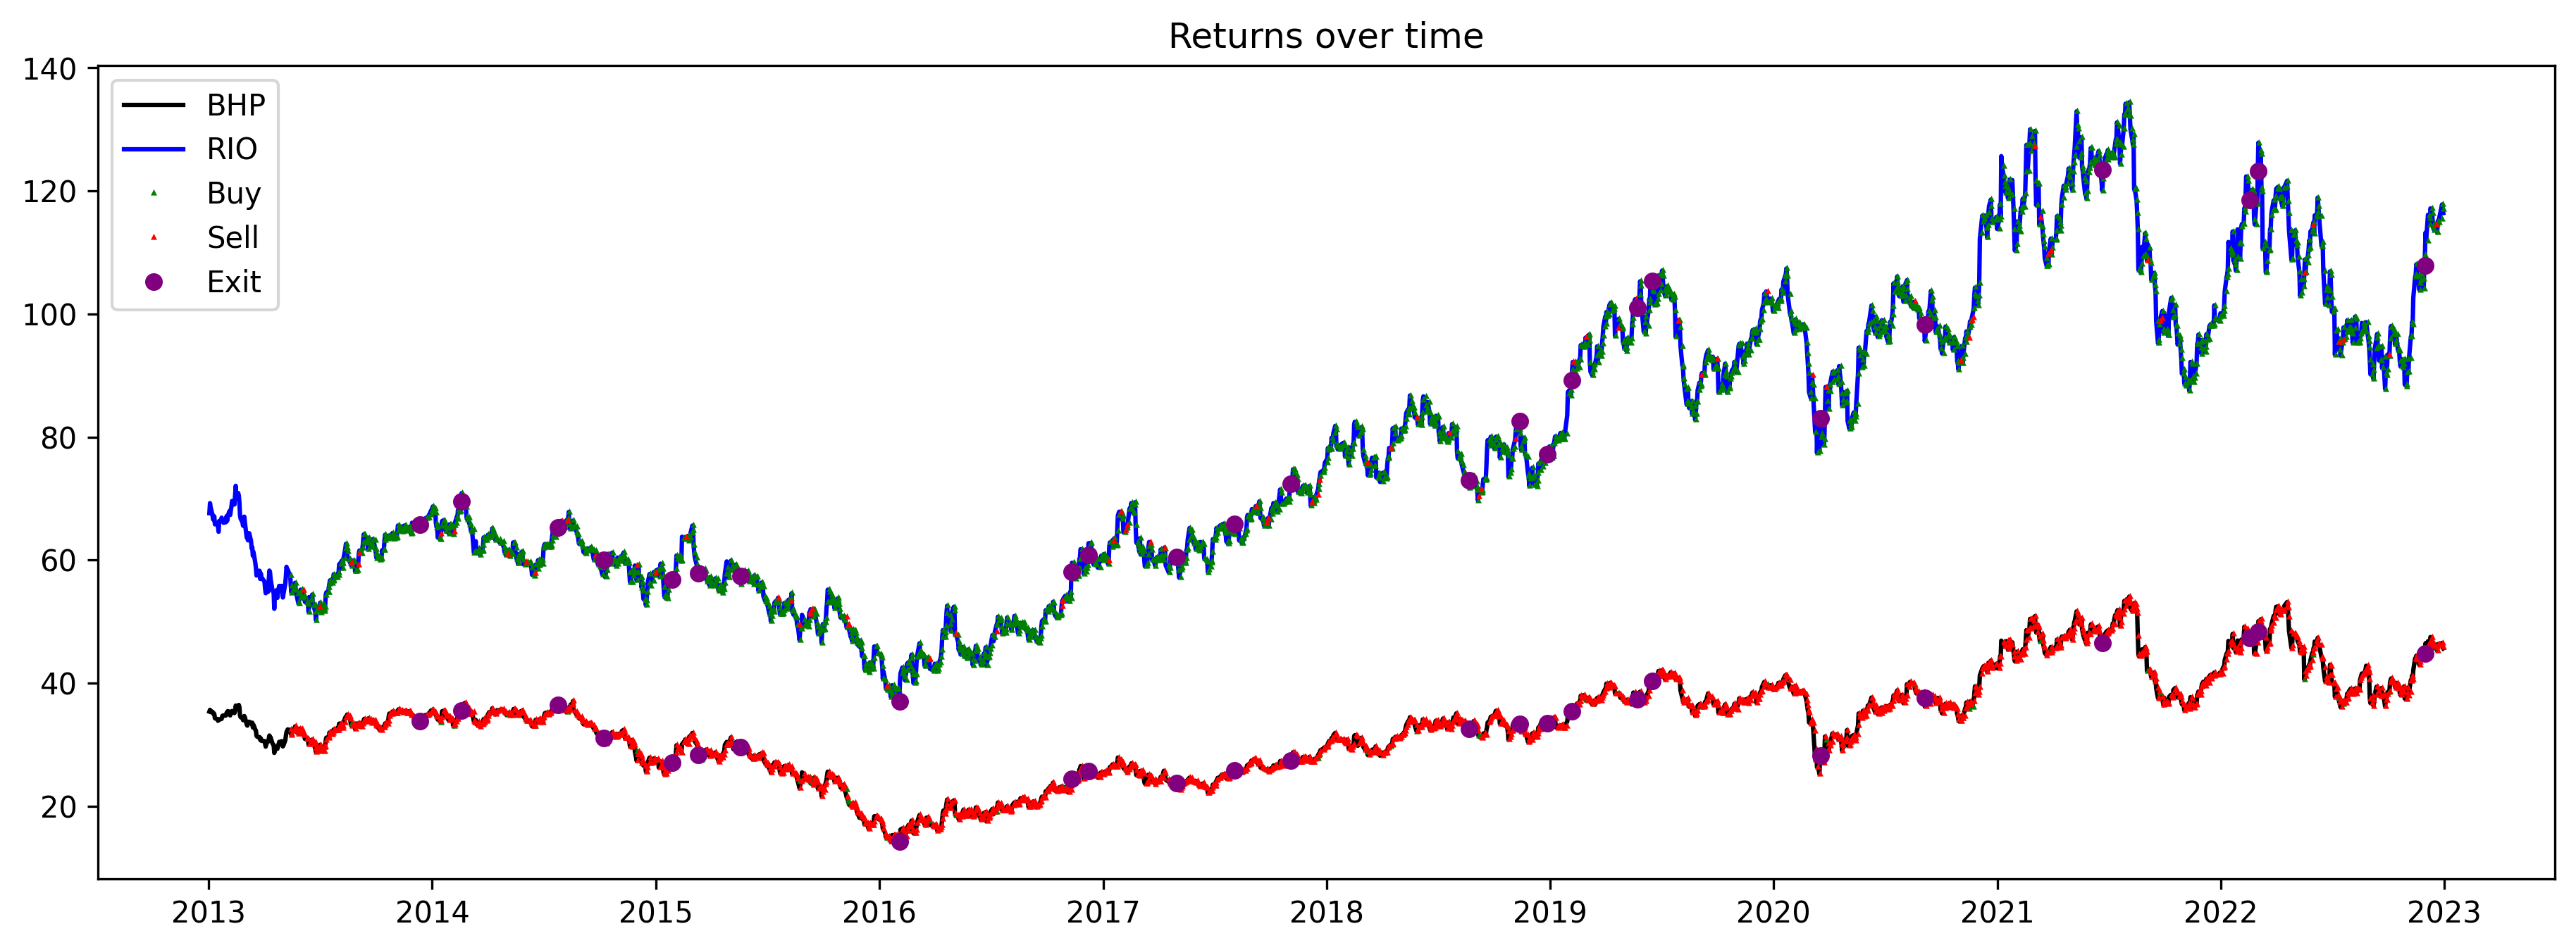

In [225]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time")
plt.plot(S1, color='black')
plt.plot(S2, color='blue')
plt.plot(buy.where(buy>0), color='green', linestyle='None', marker='^', markersize=0.5)
plt.plot(sell.where(sell>0), color='red', linestyle='None', marker='^', markersize=0.5)
plt.plot(liquidateS1.where(liquidateS1>0), color='purple', linestyle='None', marker='o', markersize=5)
plt.plot(liquidateS2.where(liquidateS2>0), color='purple', linestyle='None', marker='o', markersize=5)
plt.legend(['BHP', 'RIO', 'Buy', 'Sell', 'Exit'])
plt.show()

# Rolling copula with changing type

In [231]:
def simulate_trades(data, name_S1 = "BHP.AX", name_S2 = "RIO.AX", lookback = 90, lower_CL = 0.05, upper_CL = 0.95, exit_TH = 0.5, weight_S2 = 1, start_cash = 0):

    ## Copula variables
    family = "gumbel"
    families = {"clayton":np.inf, "gumbel":np.inf, "frank":np.inf}

    ## raw close data
    S1 = data[name_S1]
    S2 = data[name_S2]
    ## Trading variables
    # desired holding weight of asset S2 in the portfolio

    returns = start_cash
    returnsSeries = 0*S1
    totalReturnsSeries = 0*S1
    tauSeries = 0*S1

    buy = 0*S1
    sell = 0*S1
    liquidateS1 = 0*S1
    liquidateS2 = 0*S1

    MI_u_v = 0*S1
    MI_v_u = 0*S1
    # totalReturnsSeries = 0*test_S1
    # buy = 0*test_S1
    # sell = 0*test_S1
    amount_S1 = 0
    amount_S2 = 0

    tau = 0
    for i in range(lookback+1, len(S1), 1): # add 1 to avoid the nan at start

        ## Setup the copula
        S1_rolling = S1[i-lookback-1:i]
        S2_rolling = S2[i-lookback-1:i]
        # log returns
        x = (np.log(S1_rolling) - np.log(S1_rolling.shift(1)))[1:]
        y = (np.log(S2_rolling) - np.log(S2_rolling.shift(1)))[1:]
        # Empirical cumulative distribution function
        ecdf_x, ecdf_y  = ECDF(x), ECDF(y)

        tau = stats.kendalltau(x,y)[0]
        tauSeries[i] = tau
        theta = get_parameter(family, tau)

        coef = stats.linregress(x, y).slope
        
        MI_u_v[i], MI_v_u[i] = misprice_index(x[-1], y[-1], ecdf_x, ecdf_y, family, theta)

        ## Make trades 
        price_S1, price_S2 = S1_rolling[-1], S2_rolling[-1]
        
        # if S1 is undervalued and S2 is overvalued, go long
        # Sell S2 by weight, and buy S1 by weight * coefficient * long/short price ratio
        if MI_u_v[i] < lower_CL and MI_v_u[i] > upper_CL:
            # sell S2 by weight
            amount_S2 -= weight_S2
            returns += weight_S2*price_S2
            # buy S1 by weight * coefficient * long/short price ratio
            amount_S1 += (weight_S2 * coef * (price_S1/price_S2))
            returns -= (weight_S2 * coef * (price_S1/price_S2))*price_S1
            # update timeseries
            buy[i] = price_S1
            sell[i] = price_S2

        # Buy S2 by weight, sell S1 by weight * coefficient * long/short price ratio
        elif MI_u_v[i] > lower_CL and MI_v_u[i] < upper_CL:
            # buy S2 by weight
            amount_S2 += weight_S2
            returns -= weight_S2*price_S2
            # sell S1 by weight * coefficient * long/short price ratio
            amount_S1 -= (weight_S2 * coef * (price_S1/price_S2))
            returns += (weight_S2 * coef * (price_S1/price_S2))*price_S1
            # update timeseries
            sell[i] = price_S1
            buy[i] = price_S2

        # if it crosses the exit threshold, liquidate positions
        elif ((MI_u_v[i] < exit_TH and MI_u_v[i-1] > exit_TH) or (MI_u_v[i] > exit_TH and MI_u_v[i-1] < exit_TH)) \
        and ((MI_v_u[i] < exit_TH and MI_v_u[i-1] > exit_TH) or (MI_v_u[i] > exit_TH and MI_v_u[i-1] < exit_TH)):
            
            returns += amount_S1*price_S1 + amount_S2*price_S2
            amount_S1 = 0
            amount_S2 = 0

            liquidateS1[i] = price_S1
            liquidateS2[i] = price_S2

        returnsSeries[i] = returns
        totalReturnsSeries[i] = returns + amount_S1*price_S1 + amount_S2*price_S2
    return totalReturnsSeries

out = simulate_trades(data, name_S1 = "BHP.AX", name_S2 = "RIO.AX", lookback = 90, lower_CL = 0.05, upper_CL = 0.95, exit_TH = 0.5, weight_S2 = 1, start_cash = 0)
out[-1]

7426.629938554168

# Setting the signals

In [ ]:
def __init__(self, lookback_days, num_days, cap_CL, floor_CL, weight_v):
        self.lookback_days = lookback_days   # length of history data in trading period
        self.num_days = num_days             # length of formation period which determine the copula we use
        self.cap_CL = cap_CL                 # cap confidence level
        self.floor_CL = floor_CL             # floor confidence level
        self.weight_v = weight_v             # desired holding weight of asset v in the portfolio, adjusted to avoid insufficient buying power


def Update(self, algorithm: QCAlgorithm, slice: Slice) -> List[Insight]:
    insights = []

    self.SetSignal(algorithm, slice)     # only executed at first day of each month

    # Daily rebalance
    if algorithm.Time.day == self.day or slice.QuoteBars.Count == 0:
        return []
    
    long, short = self.pair[0], self.pair[1]

    if len(self.window[long]) < 2 or len(self.window[short]) < 2:
        return []
    
    # Compute the mispricing indices for u and v by using estimated copula
    MI_u_v, MI_v_u = self._misprice_index()

    # Placing orders: if long is relatively underpriced, buy the pair
    if MI_u_v < self.floor_CL and MI_v_u > self.cap_CL:
        
        insights.extend([
            Insight.Price(short, self.duration, InsightDirection.Down, weight=self.weight_v),
            Insight.Price(long, self.duration, InsightDirection.Up, weight=self.weight_v * self.coef * algorithm.Portfolio[long].Price / algorithm.Portfolio[short].Price),
        ])

    # Placing orders: if short is relatively underpriced, sell the pair
    elif MI_u_v > self.cap_CL and MI_v_u < self.floor_CL:

        insights.extend([
            Insight.Price(short, self.duration, InsightDirection.Up, weight=self.weight_v),
            Insight.Price(long, self.duration, InsightDirection.Down, weight=self.weight_v * self.coef * algorithm.Portfolio[long].Price / algorithm.Portfolio[short].Price),
        ])
    
    self.day = algorithm.Time.day
    return insights


def SetSignal(self, slice):
    '''Computes the mispricing indices to generate the trading signals.
    It's called on first day of each month'''
    if self.Time.month == self.month:
        return
    ## Compute the best copula
    # Pull historical log returns used to determine copula
    logreturns = self._get_historical_returns(self.pair, self.numdays)
    x, y = logreturns[str(self.pair[0])], logreturns[str(self.pair[1])]
    # Convert the two returns series to two uniform values u and v using the empirical distribution functions
    ecdf_x, ecdf_y  = ECDF(x), ECDF(y)
    u, v = [ecdf_x(a) for a in x], [ecdf_y(a) for a in y]
    # Compute the Akaike Information Criterion (AIC) for different copulas and choose copula with minimum AIC
    tau = kendalltau(x, y)[0]  # estimate Kendall'rank correlation
    AIC ={}  # generate a dict with key being the copula family, value = [theta, AIC]
    for i in ['clayton', 'frank', 'gumbel']:
        param = self._parameter(i, tau)
        lpdf = [self._lpdf_copula(i, param, x, y) for (x, y) in zip(u, v)]
        # Replace nan with zero and inf with finite numbers in lpdf list
        lpdf = np.nan_to_num(lpdf) 
        loglikelihood = sum(lpdf)
        AIC[i] = [param, -2 * loglikelihood + 2]
    # Choose the copula with the minimum AIC
    self.copula = min(AIC.items(), key = lambda x: x[1][1])[0]
    ## Compute the signals
    # Generate the log return series of the selected trading pair
    logreturns = logreturns.tail(self.lookbackdays)
    x, y = logreturns[str(self.pair[0])], logreturns[str(self.pair[1])]
    # Estimate Kendall'rank correlation
    tau = kendalltau(x, y)[0] 
    # Estimate the copula parameter: theta
    self.theta = self._parameter(self.copula, tau)
    # Simulate the empirical distribution function for returns of selected trading pair
    self.ecdf_x, self.ecdf_y  = ECDF(x), ECDF(y) 
    # Run linear regression over the two history return series and return the desired trading size ratio
    self.coef = stats.linregress(x,y).slope
    self.month = self.Time.month